# Wavetable Hacks!

We use a wavetable containing one cycle of our sine wave. During the update, we need to move the __playhead__ (phase) through the table and read out correct values.

In the original straightforward implementation, we used a normalized floating value to represent `phase` and converted it to an index by multiplying by `TABLE_SIZE`. We would like to optimize our bit of code using the following strategy:

1. use an unsigned int to represent `phase`;
2. take advantage of the integer overflow to automatically loop-around the wavetable for us;
3. represent `frequency` as a customized setting for `phaseIncrement` (determine how we alter our step through the table).

To do all this, we are going to use an `unsigned long` for phase. That is, we have `2^32` integer values representing phase positions:

In [21]:
WAVE_BITS = 16
TABLE_SIZE = 1 << WAVE_BITS # left-shift equivalent to 2**WAVE_BITS
print("TABLE_SIZE: {0}".format(TABLE_SIZE))
print("TABLE SIZE IN BYTES: {0}".format(TABLE_SIZE * 4)) # 4 is "sizeof(float)"
print("phase values (unsigned long): {0}".format(1 << 32))

TABLE_SIZE: 65536
TABLE SIZE IN BYTES: 262144
phase values (unsigned long): 4294967296


We definitely don't want the table as big as our phase values above, that's a 16 GB table. So we need to translate from our phase value to the index in our wavetable, and we'd like to do that cleverly.

Simple case first. Let's assume that we have twice as many phase values as the size of our wavetable: e.g. a 15-bit wavetable and a 16-bit unsigned int representing phase. The index we are looking for in our wavetable is, simply `phase / 2`. Another way to divide-without-a-divide is to write `phase >> 1`.

In [20]:
16 >> 1

8

So let's reorganize a little. We know the bits of our index (`unsigned long` is 32), and we know the bits of our wavetable (we can customize it ourselves). The difference between the two will give us the number of bits we need to shift by to scale our larger `phase` index to our smaller wavetable index:

65536


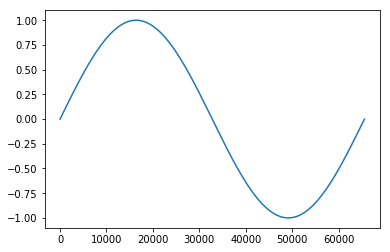

In [38]:
WAVE_BITS  = 16 # 65536 samples
INDEX_BITS = 32 # 4294967296 values
TABLE_SIZE = 1 << WAVE_BITS
BIT_COMPLIMENT = INDEX_BITS - WAVE_BITS

import numpy as np
import matplotlib.pyplot as plt

wavetable = np.sin(np.arange(TABLE_SIZE) * (2 * np.pi / TABLE_SIZE))
plt.plot(wavetable)
print(len(wavetable))

In [71]:
phases = np.arange(0, (1 << INDEX_BITS), 1 << 26)
print(phases, len(phases)) # in order, we'd expect these 64 values to be ok:

[         0   67108864  134217728  201326592  268435456  335544320
  402653184  469762048  536870912  603979776  671088640  738197504
  805306368  872415232  939524096 1006632960 1073741824 1140850688
 1207959552 1275068416 1342177280 1409286144 1476395008 1543503872
 1610612736 1677721600 1744830464 1811939328 1879048192 1946157056
 2013265920 2080374784 2147483648 2214592512 2281701376 2348810240
 2415919104 2483027968 2550136832 2617245696 2684354560 2751463424
 2818572288 2885681152 2952790016 3019898880 3087007744 3154116608
 3221225472 3288334336 3355443200 3422552064 3489660928 3556769792
 3623878656 3690987520 3758096384 3825205248 3892314112 3959422976
 4026531840 4093640704 4160749568 4227858432] 64


In [72]:
# as indices, these will def. overflow:
failtest = wavetable[phases]

IndexError: index 67108864 is out of bounds for axis 1 with size 65536

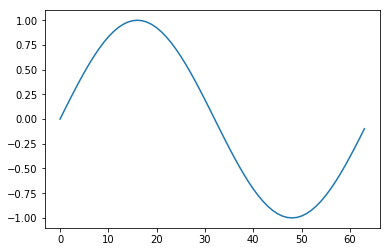

In [83]:
# but shifted by the BIT_COMPLIMENT is ok:
plt.plot(wavetable[phases >> BIT_COMPLIMENT])
plt.show()

Observe that the indices on the bottom of the image immediately above this text are far sparser than indices of our wavetable!

## Now the bit you won't like...

So the question now is "how do we represent frequency?" It's now some integer that means _"how fast we read through this wavetable"_ and we now have to do mental gymnastics for thinking about frequency as __read speed__.

But what is an index, anyway? We have an array of contiguous samples, each one `sizeof(float) == 4` bytes in size. An index to some byte array `byte* data` means that we need to compute `data + (sizeof(float) * index)` to fetch the location.

Instead, let's do this: let's just straight-up compute the memory offset in our array. We are almost there, right?

In [80]:
memOffset = phases * 4 # need to multiply by sizeof(float)

But wait a second: we're dividing by 2 using `BIT_COMPLIMENT` and then we're multiplying by 2 twice to get this memory address. Just fix this in the shift:

In [81]:
LOGBASE2OFDATASIZE = int(np.log2(4)) # for float, use 8 for doubles (it'll be 3!)
print(LOGBASE2OFDATASIZE)

2


In [86]:
phases >> (BIT_COMPLIMENT - LOGBASE2OFDATASIZE) == (phases >> BIT_COMPLIMENT) * 4

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

What's left? We need to represent `frequency` as `phaseIncrement` in our code, and we need to make sure that when we're looking for values we end up on the actual `float` boundary.